In [ ]:
!pip install opendatasets datasets librosa --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [ ]:
import opendatasets as od
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torchaudio
import re
import difflib

In [ ]:
download_url = "https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en"
od.download(download_url)

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en


In [ ]:
base_path = Path("/content/speech-emotion-recognition-en")


emotion_map = {
    "angry": "ANG",
    "disgust": "DIS",
    "fear": "FEA",
    "happy": "HAP",
    "neutral": "NEU",
    "sad": "SAD",
    "calm": "NEU",
    "surprise": "SUR",
}


def map_emotion_fuzzy(emotion_raw):
    closest = difflib.get_close_matches(emotion_raw.lower(), emotion_map.keys(), n=1)
    return emotion_map.get(closest[0]) if closest else None

def parse_crema(path):
    crema_data = []
    for wav_path in tqdm(list(Path(path).glob("*.wav")), desc="CREMA-D"):
        file_name = wav_path.name
        parts = file_name.split("_")
        if len(parts) == 4:
            speaker_id = parts[0]
            emotion = parts[2].lower()
            mapped_emotion = map_emotion_fuzzy(emotion)
            if mapped_emotion:
                crema_data.append({
                    "path": str(wav_path),
                    "emotion": mapped_emotion,
                    "speaker_id": speaker_id,
                    "dataset": "CREMA"
                })
    return pd.DataFrame(crema_data)

def parse_ravdess(path):
    ravdess_data = []
    for wav_path in tqdm(list(Path(path).rglob("*.wav")), desc="RAVDESS"):
        file_name = wav_path.name
        parts = file_name.split("-")
        if len(parts) >= 7:
            emotion_code = parts[2]
            speaker_id = parts[-1].split(".")[0]
            emotion_labels = {
                "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
                "05": "angry", "06": "fear", "07": "disgust", "08": "surprise"
            }
            raw_emotion = emotion_labels.get(emotion_code)
            mapped_emotion = map_emotion_fuzzy(raw_emotion)
            if mapped_emotion:
                ravdess_data.append({
                    "path": str(wav_path),
                    "emotion": mapped_emotion,
                    "speaker_id": speaker_id,
                    "dataset": "RAVDESS"
                })
    return pd.DataFrame(ravdess_data)

def parse_savee(path):
    savee_data = []
    emotion_map_savee = {
        "a": "ANG", "d": "DIS", "f": "FEA", "h": "HAP",
        "n": "NEU", "sa": "SAD", "su": "SUR"
    }

    for wav_path in tqdm(list(Path(path).glob("*.wav")), desc="SAVEE"):
        file_name = wav_path.stem.lower()


        match = re.search(r'_(sa|su|a|d|f|h|n)', file_name)
        if match:
            emotion_code = match.group(1)
            mapped_emotion = emotion_map_savee.get(emotion_code)
            if mapped_emotion:
                speaker_id = file_name[:2].upper()
                savee_data.append({
                    "path": str(wav_path),
                    "emotion": mapped_emotion,
                    "speaker_id": speaker_id,
                    "dataset": "SAVEE"
                })
    return pd.DataFrame(savee_data)

def parse_tess(path):
    tess_data = []
    for folder in tqdm(list(Path(path).glob("*")), desc="TESS"):
        if folder.is_dir():
            emotion_raw = folder.name.split("_")[-1].lower()
            mapped_emotion = map_emotion_fuzzy(emotion_raw)
            if mapped_emotion:
                for wav_path in folder.rglob("*.wav"):
                    speaker_id = wav_path.name.split("_")[0]
                    tess_data.append({
                        "path": str(wav_path),
                        "emotion": mapped_emotion,
                        "speaker_id": speaker_id,
                        "dataset": "TESS"
                    })
    return pd.DataFrame(tess_data)


df_crema = parse_crema(base_path / "Crema")
df_rav = parse_ravdess(base_path / "Ravdess")
df_savee = parse_savee(base_path / "Savee")
df_tess = parse_tess(base_path / "Tess")

df_all = pd.concat([df_crema, df_rav, df_savee, df_tess], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)


print(f"Total samples: {len(df_all)}")
print("Emotions:", df_all["emotion"].value_counts())
print("Datasets included:", df_all["dataset"].value_counts())

TESS: 100%|██████████| 14/14 [00:00<00:00, 309.07it/s]

Total samples: 12162
Emotions: emotion
ANG    1923
FEA    1923
DIS    1923
SAD    1923
HAP    1923
NEU    1895
SUR     652
Name: count, dtype: int64
Datasets included: dataset
CREMA      7442
TESS       2800
RAVDESS    1440
SAVEE       480
Name: count, dtype: int64


In [ ]:
# Split into train, validation and test
#train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["emotion"], random_state=42)
#val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["emotion"], random_state=42)

# Save as CSV
#os.makedirs("/content/data", exist_ok=True)
#train_df.to_csv("/content/data/train.csv", sep="\t", index=False)
#val_df.to_csv("/content/data/validation.csv", sep="\t", index=False)
#test_df.to_csv("/content/data/test.csv", sep="\t", index=False)

#print(f"Train size: {len(train_df)}")
#print(f"Validation size: {len(val_df)}")
#print(f"Test size: {len(test_df)}")

In [ ]:
from sklearn.model_selection import train_test_split

# train / val / test
train_df, temp_df = train_test_split(df_all, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

# Save
Path("/content/data").mkdir(exist_ok=True)
train_df.to_csv("/content/data/train.csv", sep="\t", index=False)
val_df.to_csv("/content/data/validation.csv", sep="\t", index=False)
test_df.to_csv("/content/data/test.csv", sep="\t", index=False)

# Report
def print_stats(name, df):
    print(f"\n{name} size: {len(df)}")
    print(f"{name} emotion distribution:\n{df['emotion'].value_counts()}")
    print(f"{name} dataset distribution:\n{df['dataset'].value_counts()}")

print_stats("Train", train_df)
print_stats("Validation", val_df)
print_stats("Test", test_df)



Train size: 8513
Train emotion distribution:
emotion
DIS    1360
SAD    1348
HAP    1346
NEU    1335
ANG    1333
FEA    1331
SUR     460
Name: count, dtype: int64
Train dataset distribution:
dataset
CREMA      5193
TESS       1978
RAVDESS     999
SAVEE       343
Name: count, dtype: int64

Validation size: 1824
Validation emotion distribution:
emotion
HAP    306
FEA    304
ANG    290
DIS    287
SAD    279
NEU    272
SUR     86
Name: count, dtype: int64
Validation dataset distribution:
dataset
CREMA      1150
TESS        396
RAVDESS     212
SAVEE        66
Name: count, dtype: int64

Test size: 1825
Test emotion distribution:
emotion
ANG    300
SAD    296
NEU    288
FEA    288
DIS    276
HAP    271
SUR    106
Name: count, dtype: int64
Test dataset distribution:
dataset
CREMA      1099
TESS        426
RAVDESS     229
SAVEE        71
Name: count, dtype: int64


In [ ]:
# Load dataset with HuggingFace datasets
from datasets import load_dataset

data_files = {
    "train": "/content/data/train.csv",
    "validation": "/content/data/validation.csv",
    "test": "/content/data/test.csv"
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

# Check a sample
print(dataset["train"][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'path': '/content/speech-emotion-recognition-en/Crema/1067_IEO_ANG_LO.wav', 'emotion': 'ANG', 'speaker_id': '1067', 'dataset': 'CREMA'}


In [ ]:
# Set column names
input_column = "path"
output_column = "emotion"

# Get unique labels
label_list = dataset["train"].unique(output_column)
label_list.sort()
num_labels = len(label_list)
print(f"Labels: {label_list}")

Labels: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD', 'SUR']


In [ ]:
# Load pretrained feature extractor
from transformers import AutoConfig, Wav2Vec2Processor

model_name = "facebook/wav2vec2-base"
pooling_mode = "mean"

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

feature_extractor = Wav2Vec2Processor.from_pretrained(model_name)
target_sampling_rate = feature_extractor.feature_extractor.sampling_rate

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
import librosa

# Updated Preprocessing with librosa
def speech_file_to_array_fn(path):
    speech, sr = librosa.load(path, sr=target_sampling_rate)  # Resample here directly
    return speech

def label_to_id(label):
    return label_list.index(label)

def preprocess_function(batch):
    speech = speech_file_to_array_fn(batch[input_column])
    batch["input_values"] = feature_extractor(speech, sampling_rate=target_sampling_rate).input_values[0]
    batch["labels"] = label_to_id(batch[output_column])
    return batch

dataset = dataset.map(preprocess_function)
print(dataset)

Map:   0%|          | 0/8513 [00:00<?, ? examples/s]

Map:   0%|          | 0/1824 [00:00<?, ? examples/s]

Map:   0%|          | 0/1825 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'emotion', 'speaker_id', 'dataset', 'input_values', 'labels'],
        num_rows: 8513
    })
    validation: Dataset({
        features: ['path', 'emotion', 'speaker_id', 'dataset', 'input_values', 'labels'],
        num_rows: 1824
    })
    test: Dataset({
        features: ['path', 'emotion', 'speaker_id', 'dataset', 'input_values', 'labels'],
        num_rows: 1825
    })
})


In [ ]:
# Define model
import torch
import torch.nn as nn
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2Model, Wav2Vec2PreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.hidden_size, config.num_labels),
        )


        self.init_weights()
        #for param in self.wav2vec2.parameters():
           # param.requires_grad = False

    def forward(self, input_values, attention_mask=None, labels=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        hidden_states = outputs[0]

        if self.pooling_mode == "mean":
            hidden_states = hidden_states.mean(dim=1)
        elif self.pooling_mode == "sum":
            hidden_states = hidden_states.sum(dim=1)
        elif self.pooling_mode == "max":
            hidden_states = hidden_states.max(dim=1)[0]
        else:
            raise ValueError(f"Invalid pooling mode: {self.pooling_mode}")

        logits = self.classifier(hidden_states)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
# Initialize model
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name, config=config)

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define data collator
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollator:
    feature_extractor: Any

    def __call__(self, features: List[Dict[str, Union[List[float], int]]]) -> Dict[str, torch.Tensor]:
        input_values = [f["input_values"] for f in features]
        labels = [f["labels"] for f in features]
        batch = self.feature_extractor.pad(
            {"input_values": input_values},
            return_tensors="pt"
        )
        batch["labels"] = torch.tensor(labels, dtype=torch.long)
        return batch

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import numpy as np

Batch = 16


data_collator = DataCollator(feature_extractor)

train_loader = DataLoader(dataset["train"], batch_size=Batch, shuffle=True, collate_fn=data_collator)
eval_loader = DataLoader(dataset["validation"], batch_size=Batch, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(dataset["test"], batch_size=Batch, shuffle=False, collate_fn=data_collator)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2ForSpeechClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
total_training_steps = len(train_loader) * 20  # num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * total_training_steps),
    num_training_steps=total_training_steps,
)

In [ ]:
# Early stopping config
early_stopping_patience = 6
best_val_loss = float("inf")
epochs_no_improve = 0

# Evaluation function
def evaluate_full(model, dataloader):
    model.eval()
    eval_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_values=input_values, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            eval_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return eval_loss / len(dataloader), correct / total


In [ ]:
#  Train loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_values=input_values, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate_full(model, eval_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(" Early stopping triggered.")
            break

Epoch 1:   0%|          | 0/533 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 533/533 [14:44<00:00,  1.66s/it]


Epoch 1 | Train Loss: 1.6903 | Train Acc: 0.3800 | Val Loss: 1.2171 | Val Acc: 0.6425


Epoch 2: 100%|██████████| 533/533 [14:38<00:00,  1.65s/it]


Epoch 2 | Train Loss: 0.9775 | Train Acc: 0.6981 | Val Loss: 0.8903 | Val Acc: 0.7122


Epoch 3: 100%|██████████| 533/533 [14:39<00:00,  1.65s/it]


Epoch 3 | Train Loss: 0.6923 | Train Acc: 0.7671 | Val Loss: 0.7580 | Val Acc: 0.7516


Epoch 4: 100%|██████████| 533/533 [14:39<00:00,  1.65s/it]


Epoch 4 | Train Loss: 0.4999 | Train Acc: 0.8328 | Val Loss: 0.6432 | Val Acc: 0.7950


Epoch 5: 100%|██████████| 533/533 [14:46<00:00,  1.66s/it]


Epoch 5 | Train Loss: 0.3952 | Train Acc: 0.8707 | Val Loss: 0.5867 | Val Acc: 0.8158


Epoch 6: 100%|██████████| 533/533 [14:46<00:00,  1.66s/it]


Epoch 6 | Train Loss: 0.3176 | Train Acc: 0.9006 | Val Loss: 0.7067 | Val Acc: 0.8004


Epoch 7: 100%|██████████| 533/533 [14:43<00:00,  1.66s/it]


Epoch 7 | Train Loss: 0.2593 | Train Acc: 0.9202 | Val Loss: 0.8611 | Val Acc: 0.7982


Epoch 8: 100%|██████████| 533/533 [14:45<00:00,  1.66s/it]


Epoch 8 | Train Loss: 0.2181 | Train Acc: 0.9399 | Val Loss: 0.8472 | Val Acc: 0.8125


Epoch 9: 100%|██████████| 533/533 [14:43<00:00,  1.66s/it]


Epoch 9 | Train Loss: 0.1795 | Train Acc: 0.9558 | Val Loss: 0.8912 | Val Acc: 0.8120


Epoch 10: 100%|██████████| 533/533 [14:45<00:00,  1.66s/it]


Epoch 10 | Train Loss: 0.1427 | Train Acc: 0.9661 | Val Loss: 1.0040 | Val Acc: 0.8169


Epoch 11: 100%|██████████| 533/533 [14:44<00:00,  1.66s/it]


Epoch 11 | Train Loss: 0.1225 | Train Acc: 0.9715 | Val Loss: 1.1703 | Val Acc: 0.8114
 Early stopping triggered.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_evaluation(model, dataloader, label_names, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_values=input_values)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")

    print("\n Classification Report:\n", classification_report(all_labels, all_preds, target_names=label_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Test Set")
    plt.tight_layout()
    plt.show()



 Classification Report:
               precision    recall  f1-score   support

         ANG       0.93      0.81      0.86       300
         DIS       0.76      0.84      0.80       276
         FEA       0.83      0.70      0.76       288
         HAP       0.85      0.85      0.85       271
         NEU       0.83      0.96      0.89       288
         SAD       0.75      0.75      0.75       296
         SUR       0.92      0.98      0.95       106

    accuracy                           0.83      1825
   macro avg       0.84      0.84      0.84      1825
weighted avg       0.83      0.83      0.83      1825



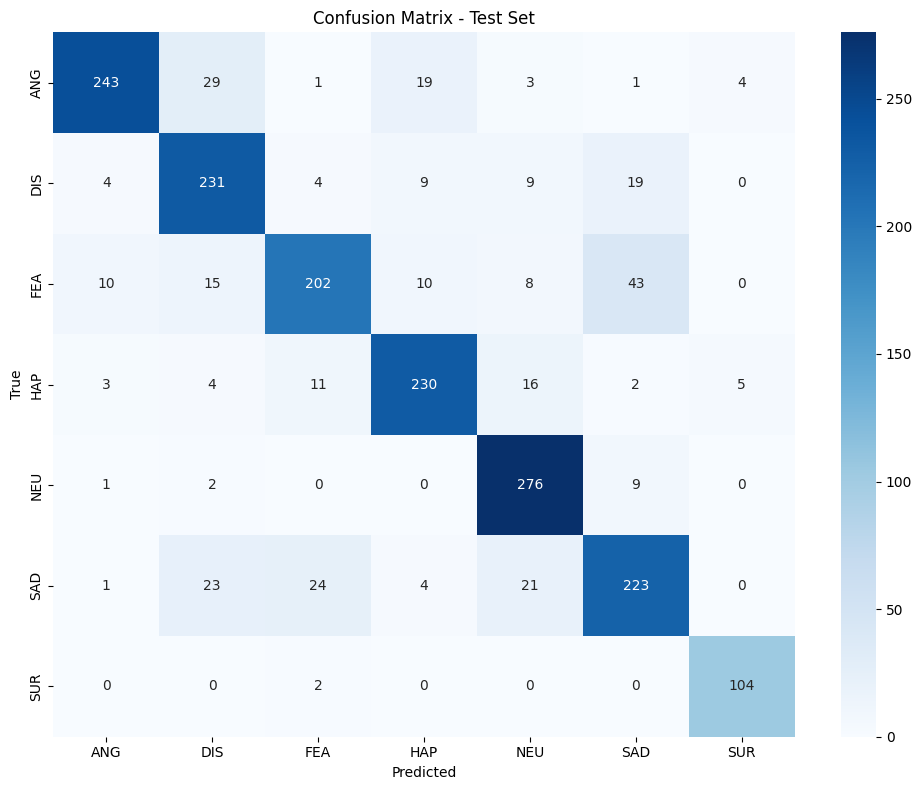

In [ ]:
label_names = list(config.id2label.values())

test_evaluation(model, test_loader, label_names, device)